In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


# Importing Packages

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

## Tensorflow imports

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Exploratory Data Analysis 

## Importing the Fake Dataset

In [4]:
fakedataset = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

In [5]:
fakedataset.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


### Number of Subjects in the Fake News Dataset

In [6]:
def diffSubjects():
    for key,count in fakedataset.subject.value_counts().iteritems():
        print(f"{key}:{count}")


diffSubjects()


News:9050
politics:6841
left-news:4459
Government News:1570
US_News:783
Middle-east:778


## Modifying the "date" Column

In [7]:
fakedataset.dropna(inplace = True) 
  
temp = fakedataset["date"].str.split(" ", n = 1, expand = True) 
  
fakedataset["Month"]= temp[0] 
  
fakedataset["date"]= temp[1] 
  
fakedataset.drop(columns =["date"], inplace = True) 

temp.dropna(inplace = True) 

Time = pd.DataFrame(columns = [0,1,2])
  
Time = temp[1].str.split(",", n = 1, expand = True) 
  
temp["Date"]= Time[0] 
  
temp["Year"]= Time[1] 
  
temp.drop(columns =["Date"], inplace = True) 
  
fakedataset.drop(columns=["Month"])

temp = temp.rename(columns={0:"Month"})


### Distribution of Data in terms of year in the Fake News Dataset

In [8]:
for key,count in Time[1].value_counts().iteritems():
    print(f"{key}:{count}")
    

 2016:11754
 2017:9203
 2015:2479


### Distribution of Data in terms on Months in the Fake News Dataset

In [9]:
for key,count in temp["Month"].value_counts().iteritems():
    print(f"{key}:{count}")

May:2177
January:1275
Oct:1250
March:1220
Jul:1174
Aug:1156
February:1154
Nov:1148
Apr:1136
Dec:1076
Sep:1061
Jun:1045
April:972
Mar:942
June:876
Jan:835
July:777
August:751
Feb:745
October:718
September:713
November:655
December:580
MSNBC:1


### Total number of elements in the Fake Dataset

In [10]:
print(f"Total Elements:{fakedataset.shape[0]}")

Total Elements:23481


## Visualisations for the Fake Dataset

### Bar plot for Year distribution

In [11]:
fig , ax = plt.subplots(1, 1, figsize=(30,30), dpi = 300)

sns.countplot("Year", data = temp)
plt.xlabel = ["Year"]
plt.xticks = []

plt.show()

### Bar plot for month-wise distribution

In [12]:
fig , ax = plt.subplots(1, 1, figsize=(30,30), dpi = 300)

sns.countplot("Month", data = temp)
plt.xlabel = ["Month"]
plt.xticks = []

plt.show()

### Countplot for subjects

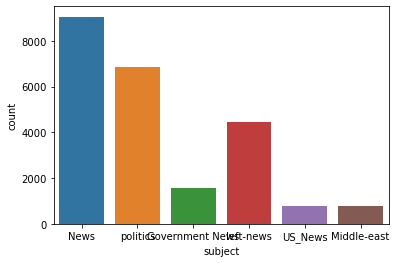

In [13]:
sns.countplot(x = "subject", data = fakedataset)

## Importing the Real Dataset

In [14]:
realdataset = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")


In [15]:
realdataset.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [16]:
[index for index,text in enumerate(realdataset.text.values) if str(text).strip == '']


[]

In [17]:
[index for index,text in enumerate(fakedataset.text.values) if str(text).strip == '']

[]

## Visualisation for Real Dataset

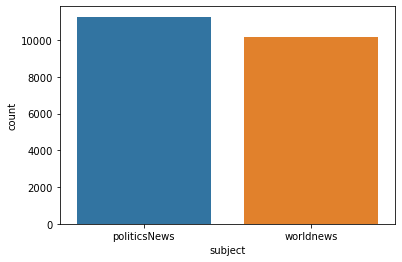

In [18]:
sns.countplot(x = "subject", data = realdataset)
plt.show()

# Some Pre-Processing

### Adding Classes to the Dataset

In [19]:
realdataset["class"] = 1
fakedataset["class"] = 0

## Real Dataset

### Making a single column for title and text

In [20]:
realdataset["text"] = realdataset["title"] + " " + realdataset["text"]


### Removing Redundant Information

In [21]:
realdataset.drop(["subject", "date", "title"], axis = 1)

,text,class
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1
...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,1
21413,LexisNexis withdrew two products from Chinese ...,1
21414,Minsk cultural hub becomes haven from authorit...,1
21415,Vatican upbeat on possibility of Pope Francis ...,1


## Fake Dataset

### Making a single Column for title and text

In [22]:
fakedataset["text"] = fakedataset["title"] + " " + fakedataset["text"]

### Removing Redundant Information

In [23]:
fakedataset.drop(["subject", "Month","title"], axis = 1)

,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
23479,How to Blow $700 Million: Al Jazeera America F...,0


## Making a joint dataframe

In [24]:
dataset = realdataset.append(fakedataset, ignore_index = True)

del realdataset, fakedataset

In [25]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
y = dataset["class"].values

x = []

stop_words = set(nltk.corpus.stopwords.words("english"))

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

for par in dataset["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    x.append(tmp)

del dataset

## Transforming our words into Vectors

In [27]:
import gensim

Embed_dim = 100

w2v = gensim.models.Word2Vec(sentences = x, size = Embed_dim , window = 5, min_count = 1)

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

x = tokenizer.texts_to_sequences(x)

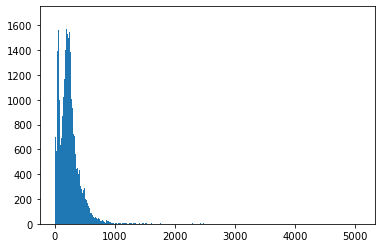

In [29]:
plt.hist([len(c) for c in x], bins = 500)
plt.show()

### Limiting No of words to 500

In [30]:
n = np.array([len(c) for c in x])
len(n[n < 500])

maxlen = 500

x = pad_sequences(x, maxlen = maxlen)

In [31]:
vocab_size = len(tokenizer.word_index) + 1

In [32]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break 

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


In [33]:
def weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    wMatrix = np.zeros((vocab_size, Embed_dim))
    for word, i in vocab.items():
        wMatrix[i] = model[word]
    return wMatrix

embed_vec = weight_matrix(w2v, word_index)

# Neural Network

In [34]:
model = Sequential()

model.add(Embedding(vocab_size, output_dim = Embed_dim, weights = [embed_vec], input_length = maxlen, trainable = False))

model.add(LSTM(units = 64))

model.add(Dense(1, activation = 'sigmoid'))

In [35]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['acc'])

In [36]:
del embed_vec

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          12237000  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 12,279,305
Trainable params: 42,305
Non-trainable params: 12,237,000
_________________________________________________________________


In [38]:
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [39]:
history = model.fit(x_train,y_train, validation_split = 0.2, epochs = 5)

Epoch 1/5
842/842 [==============================] - 22s 26ms/step - loss: 0.1092 - acc: 0.9631 - val_loss: 0.0480 - val_acc: 0.9854
Epoch 2/5
842/842 [==============================] - 21s 25ms/step - loss: 0.0415 - acc: 0.9873 - val_loss: 0.0207 - val_acc: 0.9939
Epoch 3/5
842/842 [==============================] - 22s 26ms/step - loss: 0.0213 - acc: 0.9939 - val_loss: 0.0180 - val_acc: 0.9948
Epoch 4/5
842/842 [==============================] - 21s 25ms/step - loss: 0.0112 - acc: 0.9967 - val_loss: 0.0379 - val_acc: 0.9868
Epoch 5/5
842/842 [==============================] - 21s 25ms/step - loss: 0.0128 - acc: 0.9963 - val_loss: 0.0154 - val_acc: 0.9958


In [40]:
y_pred = (model.predict(x_test) >= 0.5).astype('int')

In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5873
           1       1.00      0.99      1.00      5352

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



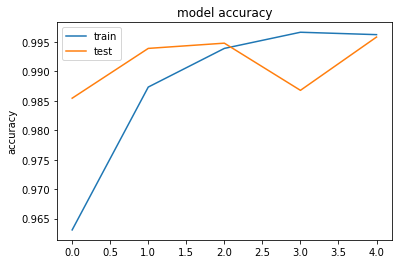

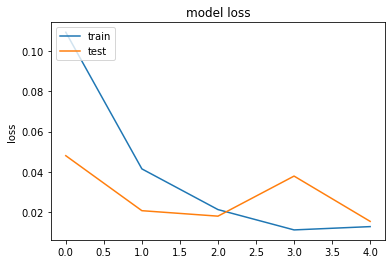

In [42]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Varied Model

In [49]:
n = np.array([len(c) for c in x])
len(n[n < 1000])

maxlen = 1000

x = pad_sequences(x, maxlen = maxlen)

vocab_size = len(tokenizer.word_index) + 1

word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break 
        

embed_vec = weight_matrix(w2v, word_index)

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


In [50]:
modelv1 = Sequential()

modelv1.add(Embedding(vocab_size, output_dim = Embed_dim, weights = [embed_vec], input_length = maxlen, trainable = False))

modelv1.add(LSTM(units = 128))

modelv1.add(Dense(1, activation = 'sigmoid'))

modelv1.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['acc'])

del embed_vec

In [51]:
modelv1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         12237000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 12,354,377
Trainable params: 117,377
Non-trainable params: 12,237,000
_________________________________________________________________


In [52]:
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [53]:
history = modelv1.fit(x_train,y_train, validation_split = 0.4, epochs = 5)

Epoch 1/5
632/632 [==============================] - 41s 65ms/step - loss: 0.1272 - acc: 0.9567 - val_loss: 0.0629 - val_acc: 0.9817
Epoch 2/5
632/632 [==============================] - 40s 64ms/step - loss: 0.0937 - acc: 0.9668 - val_loss: 0.0701 - val_acc: 0.9788
Epoch 3/5
632/632 [==============================] - 40s 63ms/step - loss: 0.0382 - acc: 0.9874 - val_loss: 0.0277 - val_acc: 0.9924
Epoch 4/5
632/632 [==============================] - 41s 64ms/step - loss: 0.0223 - acc: 0.9924 - val_loss: 0.0393 - val_acc: 0.9854
Epoch 5/5
632/632 [==============================] - 41s 64ms/step - loss: 0.0144 - acc: 0.9951 - val_loss: 0.0193 - val_acc: 0.9945


In [54]:
y_pred = (model.predict(x_test) >= 0.5).astype('int')

In [55]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5957
           1       1.00      0.98      0.99      5268

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



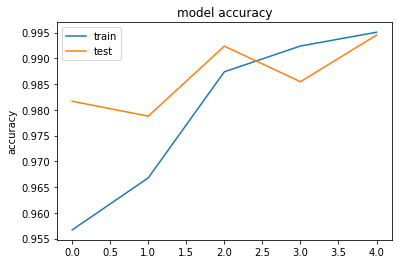

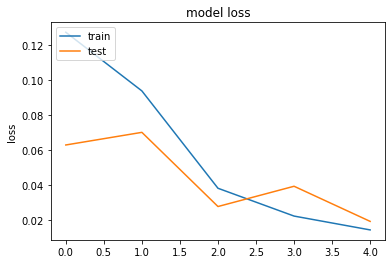

In [56]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Version 3

In [57]:
maxlen = 1000

x = pad_sequences(x, maxlen = maxlen)

vocab_size = len(tokenizer.word_index) + 1

word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break 
        

embed_vec = weight_matrix(w2v, word_index)

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


In [62]:
from tensorflow.keras import regularizers

modelv2 = Sequential()

modelv2.add(Embedding(vocab_size, output_dim = Embed_dim, weights = [embed_vec], input_length = maxlen, trainable = False))

modelv2.add(LSTM(units = 128,  kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))

modelv2.add(Dense(1, activation = 'sigmoid'))

modelv2.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['acc'])

del embed_vec

In [63]:
modelv2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 100)         12237000  
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 12,354,377
Trainable params: 117,377
Non-trainable params: 12,237,000
_________________________________________________________________


In [64]:
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [65]:
history = modelv2.fit(x_train,y_train, validation_split = 0.2, epochs = 5)

Epoch 1/5
842/842 [==============================] - 46s 55ms/step - loss: 1.0036 - acc: 0.9315 - val_loss: 0.3913 - val_acc: 0.9544
Epoch 2/5
842/842 [==============================] - 45s 54ms/step - loss: 0.2914 - acc: 0.9440 - val_loss: 0.2458 - val_acc: 0.9559
Epoch 3/5
842/842 [==============================] - 45s 54ms/step - loss: 0.2402 - acc: 0.9431 - val_loss: 0.2625 - val_acc: 0.9351
Epoch 4/5
842/842 [==============================] - 46s 54ms/step - loss: 0.2290 - acc: 0.9462 - val_loss: 0.2230 - val_acc: 0.9476
Epoch 5/5
842/842 [==============================] - 45s 53ms/step - loss: 0.1805 - acc: 0.9581 - val_loss: 0.1673 - val_acc: 0.9645


In [66]:
y_pred = (model.predict(x_test) >= 0.5).astype('int')

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5869
           1       1.00      0.98      0.99      5356

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



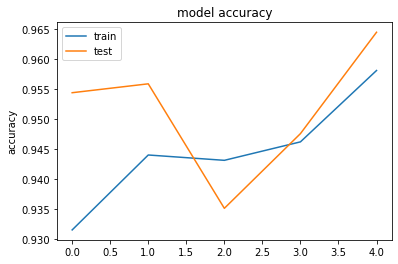

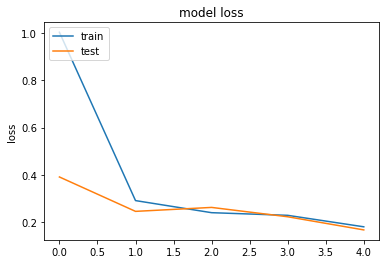

In [68]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()